## Семинар 7: "Методы оптимизации"

ФИО: Перфильева Нелли Андреевна

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.autograd import Variable
from IPython.display import clear_output

%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [2]:
class Optimizer:
    def __init__(self, parameters):
        self.parameters = list(parameters)

    def zero_grad(self):
        for param in self.parameters:      
            param.grad.zero_()
  
    def step(self, F):
        loss = F()
        loss.backward()        

In [3]:
class SGD(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        self.learning_rate = learning_rate
    
    def step(self, F):
        super().step(F)
        with torch.no_grad():
            for param in self.parameters:
                param -= self.learning_rate * param.grad

In [4]:
class Momentum(Optimizer):
    def __init__(self, parameters, learning_rate=0.001, gamma=0.9):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.v = [torch.zeros_like(param) for param in self.parameters]
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                param -= v

In [5]:
class NAG(Optimizer):
    def __init__(self, parameters, learning_rate=0.001, gamma=0.9):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.v = [torch.zeros_like(param) for param in self.parameters]
        self.gamma = gamma
    
    def step(self, F):
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param -= v * self.gamma
        super().step(F)
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param += v * self.gamma
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                param -= v

In [6]:
class RMSProp(Optimizer):
    def __init__(self, parameters, learning_rate=0.1, gamma=0.9):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 10e-9
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                param -= self.learning_rate * param.grad / torch.sqrt(g + self.eps)

In [7]:
class Adagrad(Optimizer):
    def __init__(self, parameters, eps=1e-8, learning_rate=0.1):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = eps
        
    def step(self, F):
        super().step(F)
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_(g + param.grad**2)
                param -= self.learning_rate / torch.sqrt(g + self.eps) * param.grad

In [8]:
class Adadelta(Optimizer):
    def __init__(self, parameters, gamma=0.9, learning_rate=0.9):
        super().__init__(parameters)
        self.params_g = [torch.zeros_like(param) for param in self.parameters]
        
        self.first_call = True
        
        self.lr = learning_rate
        self.eps = 0.00001
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        sum_step = 0
        num_params = 0
        with torch.no_grad():
            for param, gs in zip(self.parameters, self.params_g):
                if not self.first_call:
                    g.copy_(self.gamma * g + (1.0 - self.gamma) * param.grad ** 2)
                else:
                    g.copy_(param.grad ** 2)

                step = self.lr / (g + self.eps).sqrt() * param.grad
                sum_step += step.sum()
                num_params += step.numel()
                param -= step

        self.lr = self.gamma * self.lr + (1 - self.gamma) * sum_step / num_params
        self.first_call = False


In [9]:
class Adam(Optimizer):
    def __init__(self, parameters, learning_rate=0.1, beta_1=0.9, beta_2=0.999, gamma=0.9, eps = 1e-8):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.b1 = beta_1
        self.b2 = beta_2
        self.step_num = 1
        self.eps = 10e-8
        self.m_t = [torch.zeros_like(param) for param in self.parameters]
        self.v_t = [torch.zeros_like(param) for param in self.parameters]
    
    def step(self, F):
        super().step(F)
        with torch.no_grad():
            for m_t, v_t, param in zip(self.m_t, self.v_t, self.parameters):
                m_t.copy_(self.b1 * m_t + (1 - self.b1) * param.grad)
                v_t.copy_(self.b2 * v_t + (1 - self.b2) * param.grad ** 2)
                m_t_hat = m_t / (1 - self.b1 ** self.step_num)
                v_t_hat = v_t / (1 - self.b2 ** self.step_num)
                param -= self.learning_rate / (torch.sqrt(v_t_hat) + self.eps) * m_t_hat
            self.step_num += 1
#             self.zero_grad()

In [10]:
def create_plot(func, func_scatter, optimizers, colours, learning_rates, first_point=[2.5, 1.5]):
    x_0 = np.array(first_point).reshape(1, -1)

    optim_path = []

    for optim, lr in zip(optimizers, learning_rates):
        x = torch.tensor(x_0, requires_grad=True)
        optim = optim([x], learning_rate = lr)
        points = []
        for i in range(200):
            p_z = func(x).item()
            p_x, p_y = x.detach().numpy().flatten()        
            points.append((p_x, p_y, p_z))
            optim.step(lambda: func(x))
            optim.zero_grad()
        optim_path.append(np.array(points))
        
    fig = plt.figure(figsize=(14, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    names = []
    for optim in optimizers:
        names.append(optim.__name__)
        
    for colour, path, name in zip(colours, optim_path, names):
        points = np.array(path)
        points += np.random.rand(3) * 0.04
        ax.plot(points[:, 0], points[:, 1], points[:, 2], color=colour, linewidth=5, label = name)
    plt.legend()
    plt.show()
    
    for color, path, name in zip(colours, optim_path, names):
        points = np.array(path)        
        plt.plot(points[:, 0], points[:, 1], color=color, linewidth=5, label = name)
        
    plt.legend()
    plt.show()
        
    fig_1 = plt.figure(figsize=(7, 7))
    for color, path, name in zip(colours, optim_path, names):
        points = np.array(path)        
        plt.scatter(points[:, 0], points[:, 1], color=color, s = 3, label = name)
    plt.scatter(first_point[0], first_point[1], color="red", s = 100, marker = "x")
    plt.scatter([0], [0], color="black", s = 15)

    X = np.linspace(-2.6, 2.6, 100)
    Y = np.linspace(-2.6, 2.6, 100)
    X, Y = np.meshgrid(X, Y)
    Z = func_scatter(X, Y)
    con = plt.contour(X, Y, Z)

    fig.set_figwidth(8)    #  ширина и
    fig.set_figheight(8)    #  высота "Figure"
    plt.legend()
    plt.show()

In [11]:
optimizers = [SGD, Momentum, NAG, RMSProp, Adagrad, Adadelta, Adam]
colours = ["red", "orange", "yellow", "green", "blue", "purple", "grey"]
names = []
for optim in optimizers:
    names.append(optim.__name__)

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [12]:
def F_1(x):
    x, y = x[:, 0], x[:, 1]
    return x**2 + y**2

def F_1_scatter(x, y):
    return x**2 + y**2

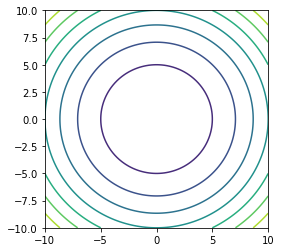

In [13]:
fig_1 = plt.figure(figsize=(4, 4))

X = np.linspace(-10, 10, 100)
Y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(X, Y)
Z = F_1_scatter(X, Y)
con = plt.contour(X, Y, Z)

plt.show()

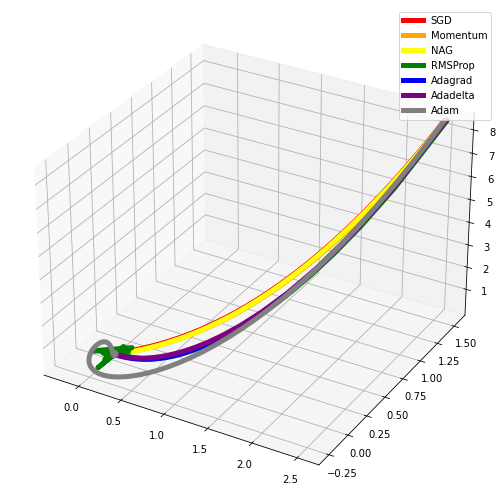

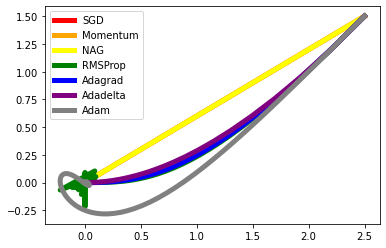

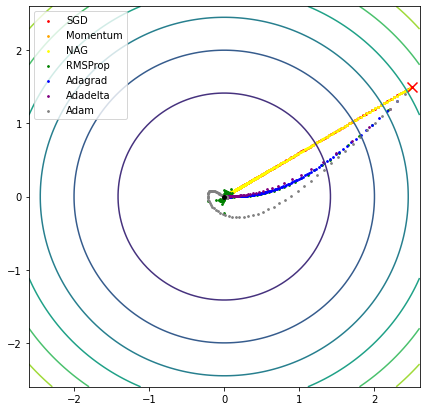

In [14]:
optimizers = [SGD, Momentum, NAG, RMSProp, Adagrad, Adadelta, Adam]
colours = ["red", "orange", "yellow", "green", "blue", "purple", "grey"]
learning_rates = [0.01, 0.001, 0.001, 0.1, 0.2, 0.3, 0.1]

create_plot(F_1, F_1_scatter, optimizers, colours, learning_rates)

In [15]:
def F_1(x, y):
    return x**2 + y**2

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [16]:
def F_2(x):    
    x, y = x[:, 0], x[:, 1]
    return (torch.sin(x**2) * x**2 + torch.sin(y**2) * y**2)

def F_2_scatter(x, y):
    return x**2 * np.sin(x) + y**2 * np.sin(y)

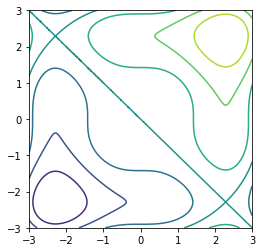

In [17]:
fig_2 = plt.figure(figsize=(4, 4))
X = np.linspace(-3, 3, 500)
Y = np.linspace(-3, 3, 500)
X, Y = np.meshgrid(X, Y)
Z = F_2_scatter(X, Y)
con = plt.contour(X, Y, Z)

# fig.set_figwidth(8)    #  ширина и
# fig.set_figheight(8)    #  высота "Figure"

plt.show()

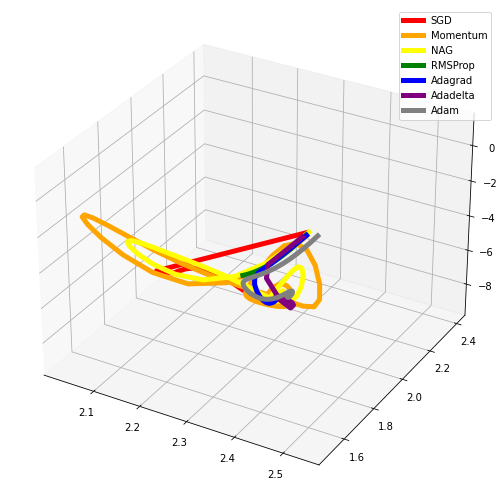

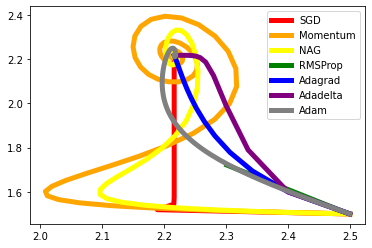

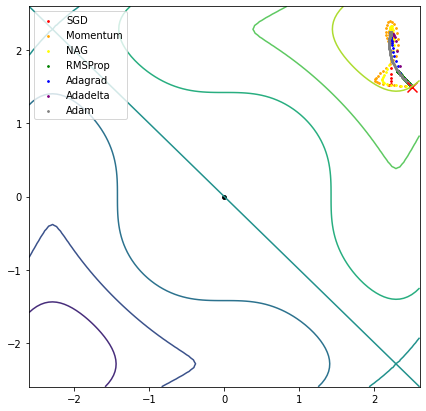

In [18]:
optimizers = [SGD, Momentum, NAG, RMSProp, Adagrad, Adadelta, Adam]
colours = ["red", "orange", "yellow", "green", "blue", "purple", "grey"]
learning_rates = [0.01, 0.001, 0.001, 0.001, 0.1, 0.1, 0.01]
point = [2.5, 1.5]

create_plot(F_2, F_2_scatter, optimizers, colours, learning_rates, point)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [19]:
def F_3(x):    
    x, y = x[:, 0], x[:, 1]
    return (torch.sin(x**2) * x**2 + torch.sin(y**2) * y**2)

def F_3_scatter(x, y):
    return x**2 * np.sin(x**2) + y**2 * np.sin(y**2)

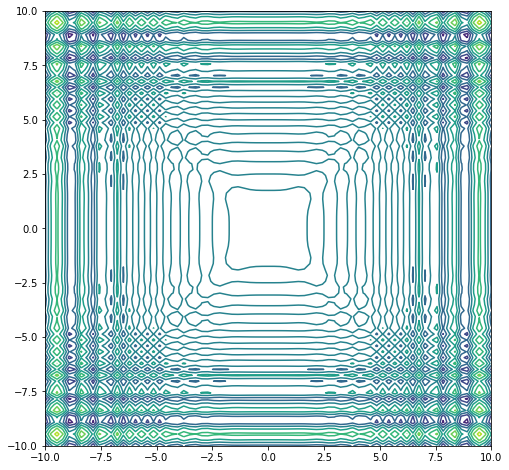

In [20]:
fig_3 = plt.figure(figsize=(10, 9))

X = np.linspace(-10, 10, 75)
Y = np.linspace(-10, 10, 75)
X, Y = np.meshgrid(X, Y)
Z = F_3_scatter(X, Y)
con = plt.contour(X, Y, Z)

fig_3.set_figwidth(8)    #  ширина и
fig_3.set_figheight(8)    #  высота "Figure"

plt.show()

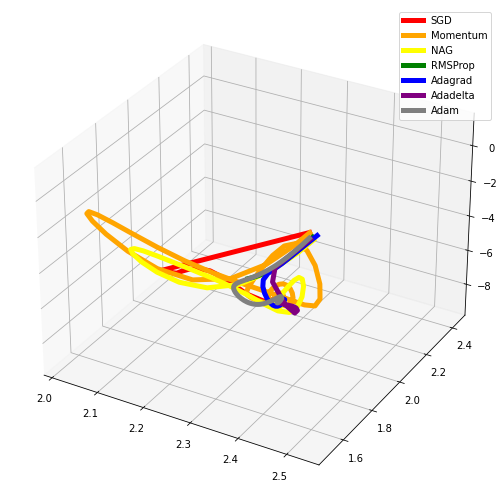

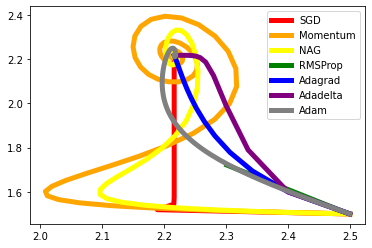

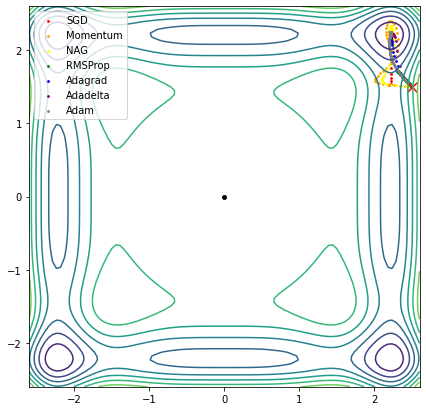

In [21]:
optimizers = [SGD, Momentum, NAG, RMSProp, Adagrad, Adadelta, Adam]
colours = ["red", "orange", "yellow", "green", "blue", "purple", "grey"]
learning_rates = [0.01, 0.001, 0.001, 0.001, 0.1, 0.1, 0.01]
# point = [2.5, 1.3]

create_plot(F_3, F_3_scatter, optimizers, colours, learning_rates)

Визуализация линий уровня помогает отслеживать положение минимумов. Стоит отметить, что для каждого случая нужно учитывать свой leraning rate в зависимости от функции и от используемого оптимизатора

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i>

In [23]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-10-30 21:43:15--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-10-30 21:43:15--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.9’

MNIST.tar.gz.9          [                 <=>]  33.20M   939KB/s    in 27s     

2021-10-30 21:43:43 (1.22 MB/s) - ‘MNIST.tar.gz.9’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [24]:
transform = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [25]:
def train(network, epochs, optimizer):
    loss = nn.NLLLoss()
    
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = lambda: loss(prediction, y)
                with torch.no_grad():
                    losses.append( loss_batch().item() )
                optimizer.step( loss_batch )
                optimizer.zero_grad()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
                
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))

            plt.figure(figsize=(14,5))
            plt.subplot(1, 2, 1)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
            
    except KeyboardInterrupt:
        pass

In [26]:
def linear_layer(opt, lr=0.01):
    network = nn.Sequential(nn.Flatten(), nn.Linear(28 * 28 * 1, 100), nn.Sigmoid(),
                                       nn.Linear(100, 100), nn.Sigmoid(),
                                       nn.Linear(100, 10), nn.LogSoftmax(dim=1))
    
    optimizer = opt(network.parameters(), learning_rate=lr)
    train(network, 5, optimizer)

Epoch 4... (Train/Test) NLL: 0.191/0.214	Accuracy: 0.942/0.934


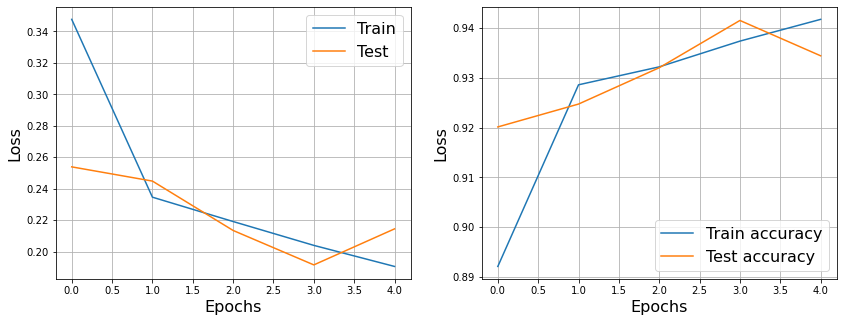

In [27]:
linear_layer(Adam, lr = 0.01)

Epoch 4... (Train/Test) NLL: 0.102/0.138	Accuracy: 0.970/0.960


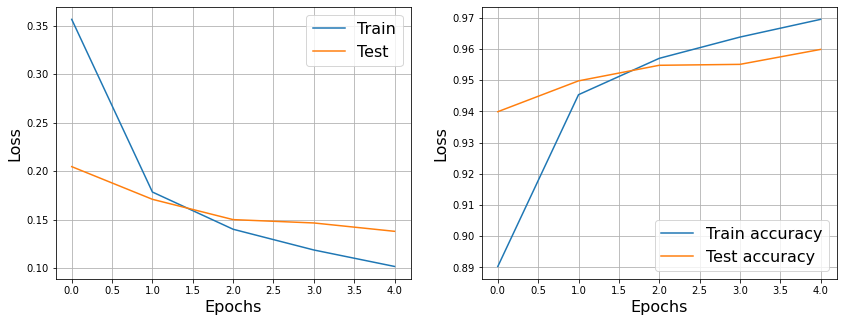

In [28]:
linear_layer(Adagrad, lr = 0.1)

Epoch 4... (Train/Test) NLL: 0.163/0.160	Accuracy: 0.953/0.953


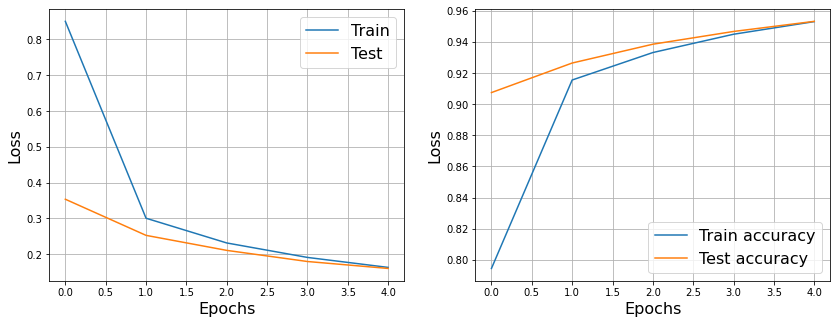

In [29]:
linear_layer(Adadelta, lr = 0.01)


Epoch 4... (Train/Test) NLL: 0.482/0.427	Accuracy: 0.879/0.890


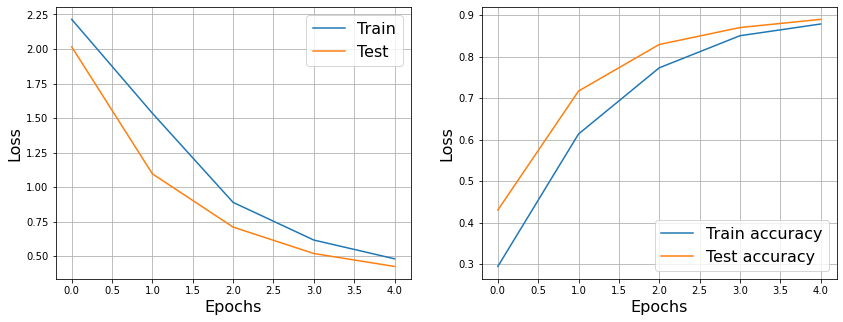

In [30]:
linear_layer(SGD, lr = 0.01)


Как и ожидалось, оптимизаторы показали лучший результат по отношению к SGD. В случае полносвязной нейронной сети наилучшим оказался Adagrad

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [31]:
image_size = 28
channels = 1
class Net(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(nn.Conv2d(channels, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.conv_layer_2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                          nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
                                          nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//4*image_size//4*64, 100), nn.ReLU(),
                                           nn.Linear(100, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.016/0.030	Accuracy: 0.995/0.992


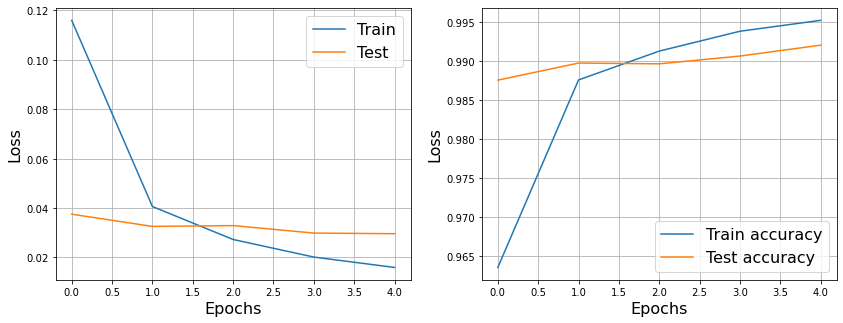

In [32]:
convNet = Net(image_size=28)
train(convNet, 5, Adam(convNet.parameters(), learning_rate=0.001))

Epoch 4... (Train/Test) NLL: 0.025/0.031	Accuracy: 0.992/0.990


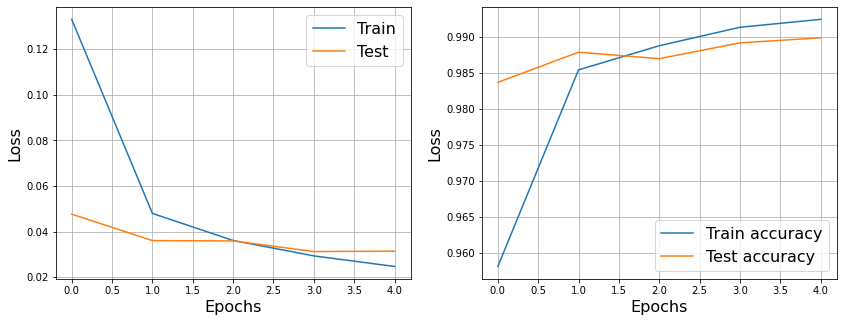

In [33]:
convNet = Net(image_size=28)
train(convNet, 5, Adagrad(convNet.parameters(), learning_rate=0.01))

Epoch 4... (Train/Test) NLL: 0.022/0.029	Accuracy: 0.993/0.990


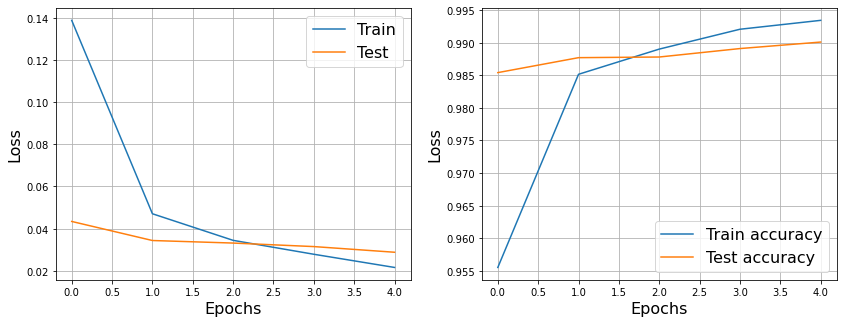

In [34]:
convNet = Net(image_size=28)
train(convNet, 5, Adadelta(convNet.parameters(), learning_rate=0.01))

Epoch 4... (Train/Test) NLL: 0.041/0.041	Accuracy: 0.987/0.986


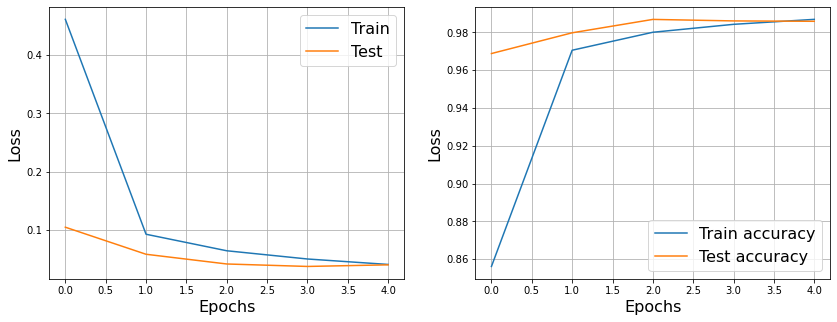

In [35]:
convNet = Net(image_size=28)
train(convNet, 5, SGD(convNet.parameters(), learning_rate=0.01))

Архитектура сверточной сети взята из Practice_task_4 (CNN)(в рамках той домашней работы она дала наилучший результат)

In [42]:
image_size = 28
channels = 1
class Net(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(nn.Conv2d(channels, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.conv_layer_2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU())        
        self.linear_layer_1 = nn.Sequential(nn.Linear(image_size//2*image_size//2*64, 50), 
                                           nn.ReLU())
        self.linear_layer_2 = nn.Sequential(nn.Linear(50, 10), nn.LogSoftmax(dim=1))

            
    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)

        x = x.view(x.size(0), -1)
        x = self.linear_layer_1(x)
        x = self.linear_layer_2(x)
        return x

Epoch 4... (Train/Test) NLL: 0.013/0.033	Accuracy: 0.996/0.991


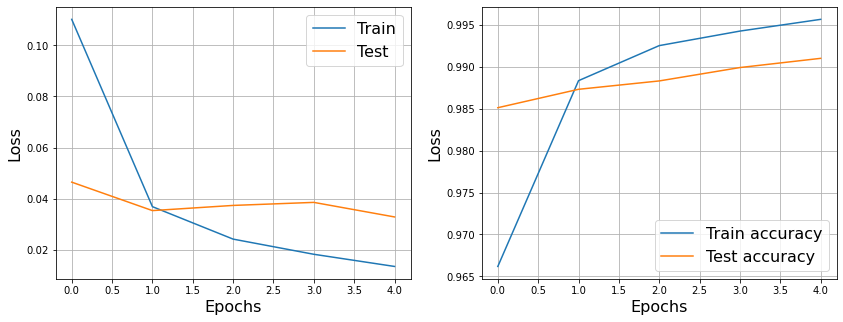

In [43]:
convNet = Net(image_size=28)
train(convNet, 5, Adam(convNet.parameters(), learning_rate=0.001))

Epoch 4... (Train/Test) NLL: 0.025/0.032	Accuracy: 0.993/0.989


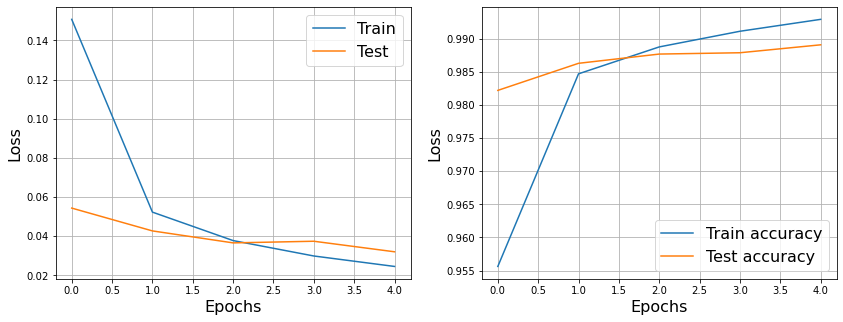

In [44]:
convNet = Net(image_size=28)
train(convNet, 5, Adagrad(convNet.parameters(), learning_rate=0.01))

Epoch 4... (Train/Test) NLL: 0.029/0.033	Accuracy: 0.992/0.989


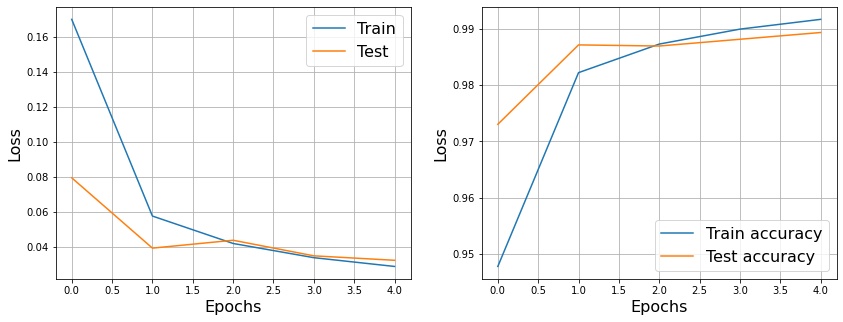

In [45]:
convNet = Net(image_size=28)
train(convNet, 5, Adadelta(convNet.parameters(), learning_rate=0.01))

Epoch 11... (Train/Test) NLL: 0.017/0.033	Accuracy: 0.995/0.988


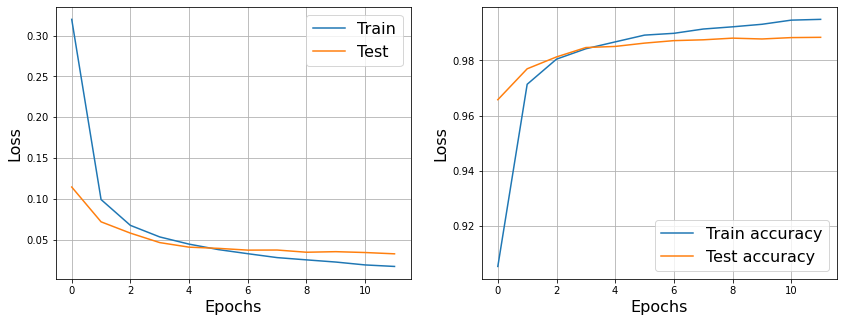

In [47]:
convNet = Net(image_size=28)
train(convNet, 12, SGD(convNet.parameters(), learning_rate=0.01))

В случае сверточной сети наилучший результат показал оптимизатор Adam. Следует отметить, что точность увеличилась на 0.02

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: